# Components of a Trading Strategy

#### Indicators
Indicators are mathematical calculations based on historical price, volume, or open interest information that traders use to predict future price movements. Some common types include:
- **Trend Indicators**: Moving Averages (SMA, EMA), Moving Average Convergence Divergence (MACD)
- **Momentum Indicators**: Relative Strength Index (RSI), Stochastic Oscillator
- **Volatility Indicators**: Bollinger Bands, Average True Range (ATR)
- **Volume Indicators**: On-Balance Volume (OBV), Volume Weighted Average Price (VWAP)

**SEE NOTEBOOK NUMBER 02**


#### Entry Point
The entry point is the specific price or condition under which you decide to enter a trade. Key considerations for determining entry points include:
- **Signal from Indicators**: A buy signal from indicators like RSI below 30 (oversold conditions) or a bullish crossover in MACD.
- **Price Action**: Patterns such as breakouts, reversals, or trend continuation patterns (e.g., head and shoulders, flags, triangles).
- **Support and Resistance Levels**: Entering a trade when the price bounces off support or breaks through resistance.

#### Exit Point
The exit point is the specific price or condition under which you decide to close a trade. Key considerations for determining exit points include:
- **Signal from Indicators**: A sell signal from indicators like RSI above 70 (overbought conditions) or a bearish crossover in MACD.
- **Price Action**: Patterns indicating potential reversals or exhaustion.
- **Profit Targets and Stop Losses**: Predefined levels to take profit or limit losses, often based on technical levels (e.g., Fibonacci retracement levels) or a fixed percentage.



In [27]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

In [28]:
plt.style.use('seaborn-v0_8')

# Buy and hold Strategy 


In [215]:
cours = 'BTC-EUR'
actif = yf.Ticker(cours)
hist = actif.history(period="max",interval='1d')

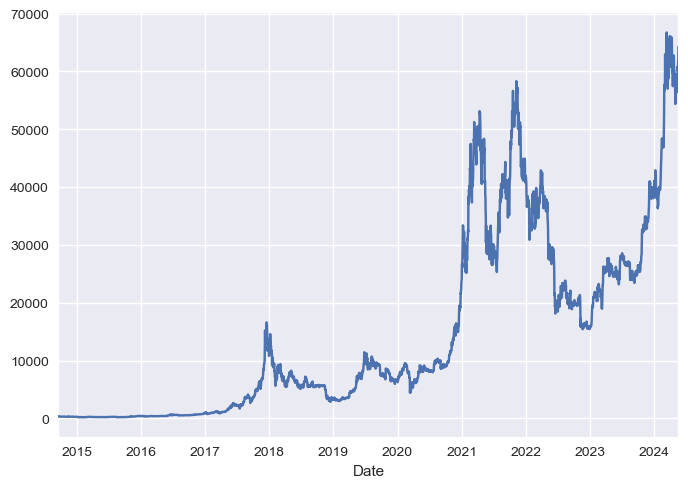

In [124]:
hist['Close'].plot()
plt.show()

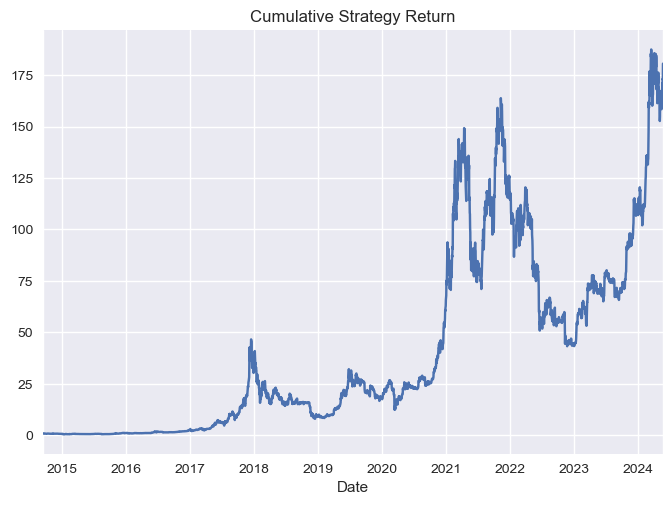

In [125]:
plt.title('Cumulative Strategy Return')
(1+hist['Close'].pct_change()).cumprod().plot()
plt.show()

In [126]:
cumulative_returns = hist.iloc[-1]['Close']/hist.iloc[0]['Close']
print(f"Cumulative Strategy Returns: {cumulative_returns:.2f}")

Cumulative Strategy Returns: 180.56


# Baseline Strategy 

## "Buy low, Sell high"

The most basic trading strategy is to buy when the asset is growing and sell when the asset is falling. To implement this, we use a 28-day rolling maximum and minimum to determine the recent highs and lows of the asset's price.

We define "close" to the recent minimum or maximum using a threshold percentage. For example, if the current price is within 5% of the 28-day rolling minimum, we generate a buy signal. Similarly, if the current price is within 5% of the 28-day rolling maximum, we generate a sell signal.


#### Signal

- **BUY** = if the current price is within 5% of the 28-day rolling minimum
- **SELL** = if the current price is within 5% of the 28-day rolling maximum,  Additionally, we also generate a sell signal if the current price drops more than 5% from the highest price since the buy signal (trailing stop loss)

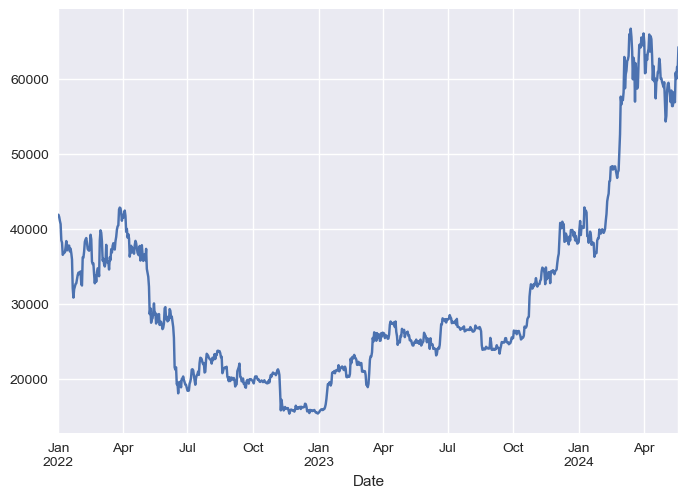

In [127]:
hist['Close'].loc['2022-01':].plot()
plt.show()

In [256]:
def calculate_rolling_extremes(df, window=5):
    df['RollingMax'] = df['Close'].shift(1).rolling(window=window).max()
    df['RollingMin'] = df['Close'].shift(1).rolling(window=window).min()
    return df

def generate_signals(df, threshold_pct=0.05):
    df['Buy'] = np.where(df['Close'] < df['RollingMin'] * (1 + threshold_pct), 1, 0)
    df['Sell'] = np.where(df['Close'] > df['RollingMax'] * (1 - threshold_pct), -1, 0)
    return df

def apply_strategy(df, threshold_pct=0.05):
    df = df.reset_index()
    # when you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    holding = False
    trade = {}
    trades = []
    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            stop_loss_price = row['buy_price'] * (1 - threshold_pct)
            trade['entry_date'] = row['day_after']
            trade['entry_price'] = row['buy_price']

        if holding:
            # Compare current close with actual SL price 
            if row['Close'] > stop_loss_price / (1 - threshold_pct):
                # Update SL
                stop_loss_price = row['Close'] * (1 - threshold_pct)
            
            # Condition to Sell bellow SL
            if row['Close'] < stop_loss_price or row['Sell'] == 1:
                holding = False
                trade['exit_date'] = row['day_after']
                trade['exit_price'] = row['buy_price'] 
                trades.append(trade) 
                trade = {}
    return df,trades


def showtrades(trades,Close,annot=False):
    # Convert date columns to datetime
    trades['entry_date'] = pd.to_datetime(trades['entry_date'])
    trades['exit_date'] = pd.to_datetime(trades['exit_date'])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each trade
    for i, row in trades.iterrows():
        color = 'g' if row['exit_price'] > row['entry_price'] else 'r'
        ax.plot([row['entry_date'], row['exit_date']], [row['entry_price'], row['exit_price']], marker='o', color=color)
    
    # Highlight entry and exit points
    ax.scatter(trades['entry_date'], trades['entry_price'], color='blue', label='Entry Points')
    ax.scatter(trades['exit_date'], trades['exit_price'], color='purple', label='Exit Points')
    ax.plot(Close,alpha=0.4)
    
    if annot:
        # Adding annotations for each trade
        for i, row in trades.iterrows():
            ax.annotate(f'{row["entry_price"]:.2f}', xy=(row['entry_date'], row['entry_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='blue')
            ax.annotate(f'{row["exit_price"]:.2f}', xy=(row['exit_date'], row['exit_price']), xytext=(10, 5), textcoords='offset points', fontsize=8, color='purple')
        
    # Formatting the plot
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title('Trade Entries and Exits', fontsize=16)
    ax.legend()
    ax.grid(True)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

In [224]:
df = calculate_rolling_extremes(hist, window=5)
df = generate_signals(df, threshold_pct=0.05)
df,trades = apply_strategy(df, threshold_pct=0.05)

In [228]:
trades = pd.DataFrame(trades)

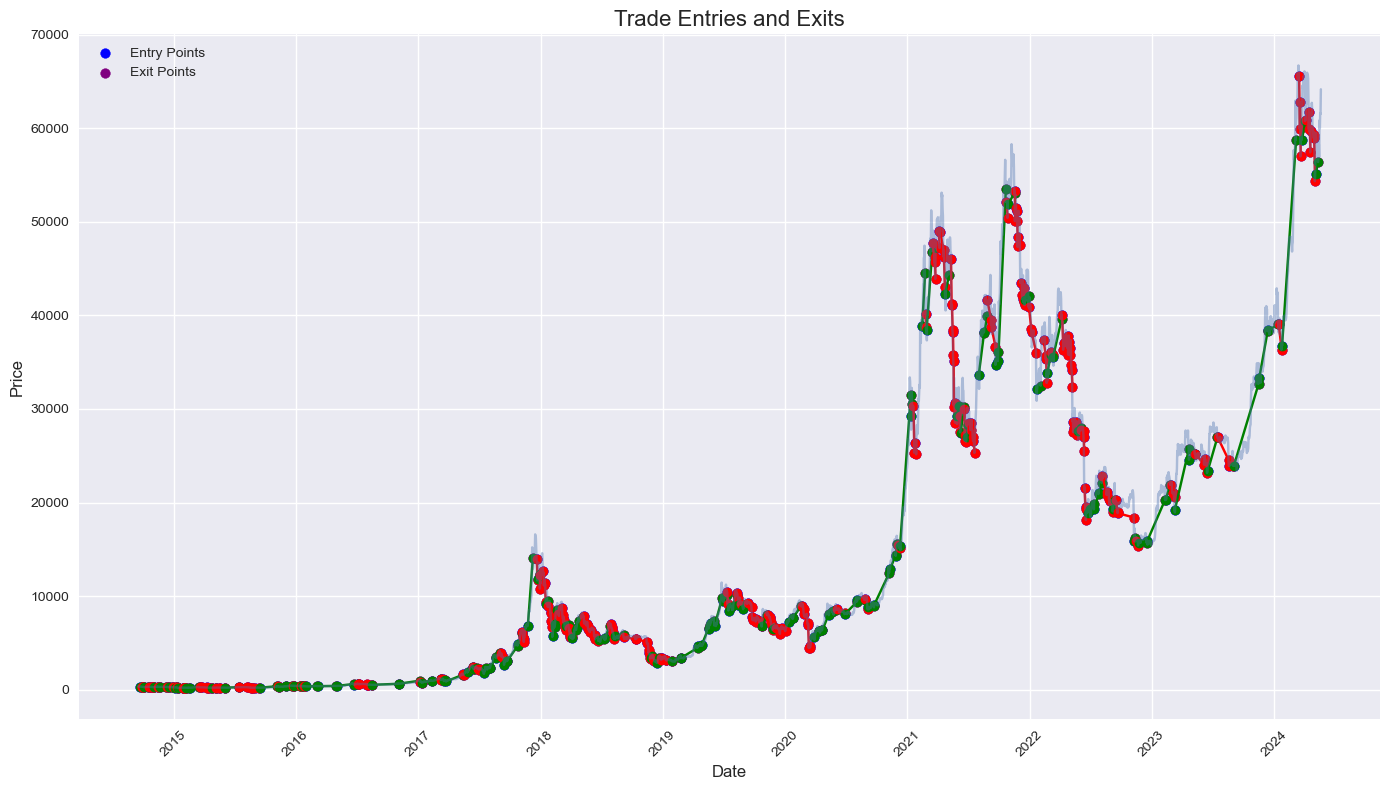

In [255]:
showtrades(trades = trades,Close = hist['Close'], annot=False)

In [260]:
# Calculate returns for each trade
trades['return'] = (trades['exit_price'] - trades['entry_price']) / trades['entry_price']

In [263]:
# Calculate performance metrics
win_rate = (trades['return'] > 0).mean()
cum_return = (1 + trades['return']).prod() - 1
std_dev = trades['return'].std()
sharpe_ratio = trades['return'].mean() / trades['return'].std() * np.sqrt(len(trades))
buy_and_hold_return = (trades['exit_price'].iloc[-1] - trades['entry_price'].iloc[0]) / trades['entry_price'].iloc[0]

In [266]:
# Report performance
performance_report = pd.DataFrame({
    'Metric': ['Win Rate', 'Standard Deviation', 'Sharpe Ratio', 'Buy and Hold Return','Cumulative Return'],
    'Value': [win_rate, std_dev, sharpe_ratio, buy_and_hold_return,cum_return]
})

In [267]:
print(performance_report)

                Metric       Value
0             Win Rate    0.406475
1   Standard Deviation    0.173622
2         Sharpe Ratio    2.712081
3  Buy and Hold Return  179.245631
4    Cumulative Return   95.252609


In [271]:
# Perform backtesting
print(f"Cumulative Strategy Returns: {cum_return:.2f}")

Cumulative Strategy Returns: 95.25


# MACD Strategy 